<a href="https://colab.research.google.com/github/rajy4683/EIP4_Phase1_Final/blob/master/ResNet_Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [0]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Conv2D, BatchNormalization, Activation



Using TensorFlow backend.


In [0]:
import tensorflow as tf

from tqdm import tqdm_notebook as tqdm

import tensorflow.contrib.eager as tfe
#tf.enable_eager_execution()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.callbacks import CyclicLR

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-oiz74km1
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-oiz74km1
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=8272dbef245ee1d1cf48cb9b83d3c7835c3a1fbb6a01275bf24f01c56a1e02a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-_v4py52t/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [0]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
one_hot_df.head()


,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
0,resized/1.jpg,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
1,resized/2.jpg,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0
2,resized/3.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0
3,resized/4.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4,resized/5.jpg,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0


In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:
train_df = pd.read_csv('/content/gdrive/My Drive/train_df_wrn2_widrn_acc_incept_1577480753.csv')
val_df=pd.read_csv('/content/gdrive/My Drive/val_df_wrn2_widrn_acc_incept_1577480753.csv')

In [0]:
from datetime import datetime
def get_curr_time():
    return int(datetime.utcnow().strftime("%s"))

model_name_itr = 'wrn2_widrn_acc_res50_'+str(get_curr_time())
gdrive_home_path="/content/gdrive/My Drive/"
train_csv=gdrive_home_path+"train_df_"+model_name_itr+".csv"
val_csv=gdrive_home_path+"val_df_"+model_name_itr+".csv"
json_file=gdrive_home_path+"json_"+model_name_itr+".json"
png_file=gdrive_home_path+"png_"+model_name_itr+".png"
weights_file=gdrive_home_path+"h5_"+model_name_itr+".h5"

print("Model-name:",model_name_itr)
print(train_csv,val_csv,json_file,png_file,weights_file)
train_df.to_csv(train_csv, index=False)
val_df.to_csv(val_csv, index=False)

# /content/gdrive/My Drive/train_df_wrn2_widrn_acc_1577202722.csv 
# /content/gdrive/My Drive/val_df_wrn2_widrn_acc_1577202722.csv 
# /content/gdrive/My Drive/json_wrn2_widrn_acc_1577202722.json
#  /content/gdrive/My Drive/png_wrn2_widrn_acc_1577202722.png 
#  /content/gdrive/My Drive/h5_wrn2_widrn_acc_1577202722.h5

Model-name: wrn2_widrn_acc_res50_1577513556
/content/gdrive/My Drive/train_df_wrn2_widrn_acc_res50_1577513556.csv /content/gdrive/My Drive/val_df_wrn2_widrn_acc_res50_1577513556.csv /content/gdrive/My Drive/json_wrn2_widrn_acc_res50_1577513556.json /content/gdrive/My Drive/png_wrn2_widrn_acc_res50_1577513556.png /content/gdrive/My Drive/h5_wrn2_widrn_acc_res50_1577513556.h5


In [0]:
#standardize_all_images(train_df)
#items = train_df.iloc[:,:]
#image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
#print(image.shape)


In [0]:
import keras
import numpy as np
from google.colab.patches import cv2_imshow
from tensorflow.python.keras.utils.data_utils import Sequence

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

#class PersonDataGenerator(keras.utils.Sequence):
class PersonDataGenerator(Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True,normalize=False,aug_flow=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.normalize = normalize
        self.on_epoch_end()
        self.aug_flow=aug_flow
        #print("Shuffle = ",self.shuffle)

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        #print(batch_slice)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        #print(items["image_path"])
        
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        if(self.aug_flow is not None):
            image = self.aug_flow.flow(image,shuffle=False).next()
        if(self.normalize == True):
            train_mean = np.mean(image, axis=(0,1,2))
            train_std = np.std(image, axis=(0,1,2))
            #print(train_mean, train_std)
            normalize = lambda x: ((x - train_mean) / train_std).astype('float32')
            image = normalize(image)


        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [0]:
output_weights = ["gender_output", "imagequality_ouput","age_output", "weight_output", "bag_output", "footwear_output","emotion_output", "pose_output"]
col_splits = [_gender_cols_, _imagequality_cols_,_age_cols_, _weight_cols_, _carryingbag_cols_, _footwear_cols_, _emotion_cols_, _bodypose_cols_]
def get_dist(train_df,equalize_classes=False):
    loss_weights = {}
    index=0
    for selector_column in col_splits:
        print(selector_column)
        count = []
        percentile = []
        for age_split in selector_column:
            count.append( train_df[selector_column][train_df[age_split] == 1].shape[0])
        #print(count, np.round((count/11537.0)*100.0, 2))

        max_val = np.max(count)
        total_count = np.float32(train_df.shape[0])
        #print(count, )
        count_weights= [np.round(max_val/current_val,3) for current_val in count]
        print(count_weights)
        print(np.round((np.asarray(count)/total_count)*100.0, 2))

        #print("Top Class:",selector_column[np.argmax(count)],"Max Count",np.max(count))
        #print("Bottom Class:",selector_column[np.argmin(count)])
        #weights_dist = dict(zip(selector_column, count_weights))
        
        #print(weights_dist)
        weights_vals_dist={}
        index_val=0
        for y in range(len(count_weights)):
            weights_vals_dist[y]=count_weights[y]
            print(weights_vals_dist[y],y)
            #index_val+=index_val
            
            #loss_weights[output_weights[index]]={x,y}
        loss_weights[output_weights[index]]=weights_vals_dist
        #if equalize_classes == True:
        #    expanded_df = equalize_classwise_dist(train_df, selector_column, count)
        #    train_df = train_df.append(expanded_df, ignore_index=True)
        index+=1
    #print(loss_weights)
    return train_df,loss_weights

In [0]:
_,loss_weights_train=get_dist(train_df, equalize_classes=False)
loss_weights_train

['gender_female', 'gender_male']
[1.275, 1.0]
[43.95 56.05]
1.275 0
1.0 1
['imagequality_Average', 'imagequality_Bad', 'imagequality_Good']
[1.0, 3.325, 1.968]
[55.28 16.62 28.09]
1.0 0
3.325 1
1.968 2
['age_15-25', 'age_25-35', 'age_35-45', 'age_45-55', 'age_55+']
[2.173, 1.0, 1.593, 3.682, 7.192]
[18.42 40.02 25.13 10.87  5.56]
2.173 0
1.0 1
1.593 2
3.682 3
7.192 4
['weight_normal-healthy', 'weight_over-weight', 'weight_slightly-overweight', 'weight_underweight']
[1.0, 9.729, 2.695, 10.119]
[63.59  6.54 23.59  6.28]
1.0 0
9.729 1
2.695 2
10.119 3
['carryingbag_Daily/Office/Work Bag', 'carryingbag_Grocery/Home/Plastic Bag', 'carryingbag_None']
[1.64, 5.732, 1.0]
[34.18  9.78 56.05]
1.64 0
5.732 1
1.0 2
['footwear_CantSee', 'footwear_Fancy', 'footwear_Normal']
[1.195, 2.389, 1.0]
[37.11 18.56 44.34]
1.195 0
2.389 1
1.0 2
['emotion_Angry/Serious', 'emotion_Happy', 'emotion_Neutral', 'emotion_Sad']
[6.479, 5.983, 1.0, 12.063]
[10.99 11.9  71.21  5.9 ]
6.479 0
5.983 1
1.0 2
12.063 3
['bod

{'age_output': {0: 2.173, 1: 1.0, 2: 1.593, 3: 3.682, 4: 7.192},
 'bag_output': {0: 1.64, 1: 5.732, 2: 1.0},
 'emotion_output': {0: 6.479, 1: 5.983, 2: 1.0, 3: 12.063},
 'footwear_output': {0: 1.195, 1: 2.389, 2: 1.0},
 'gender_output': {0: 1.275, 1: 1.0},
 'imagequality_ouput': {0: 1.0, 1: 3.325, 2: 1.968},
 'pose_output': {0: 3.774, 1: 1.0, 2: 2.79},
 'weight_output': {0: 1.0, 1: 9.729, 2: 2.695, 3: 10.119}}

In [0]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
0,resized/3350.jpg,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1
1,resized/11860.jpg,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0
2,resized/5289.jpg,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1
3,resized/7730.jpg,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0
4,resized/1822.jpg,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0


In [0]:
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(iter(batches))
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

In [0]:
import numpy as np
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()
        if p_1 > p:
            return input_img
        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)
            if left + w <= img_w and top + h <= img_h:
                break
        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)
        input_img[top:top + h, left:left + w, :] = c
        return input_img
    return eraser

In [0]:
# create train and validation data generators
BATCH_SIZE=16
aug_gen = ImageDataGenerator(horizontal_flip=True, 
                             vertical_flip=False,
                             rotation_range=5,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=[0.5,1.5],
                             shear_range=0.2,
                             #zca_whitening=True,
                             brightness_range=[0.5,1.5],
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))

train_gen = PersonDataGenerator(train_df, batch_size=BATCH_SIZE,normalize=True,aug_flow=aug_gen)
valid_gen = PersonDataGenerator(val_df, batch_size=BATCH_SIZE, shuffle=False,normalize=True)

In [0]:
CROP_LENGTH=64
train_crops = crop_generator(train_gen, CROP_LENGTH)
valid_crops = crop_generator(valid_gen, CROP_LENGTH)

In [0]:
train_gen[0]

In [0]:
def get_image_batch(data_df, batch_size=32, shuffle=True,normalize=True, selected_field='age_output'):
    new_batch = PersonDataGenerator(data_df, batch_size,shuffle, normalize)
    images, targets = next(iter(new_batch))
    num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
    labels = np.asarray([ np.argmax(targets['age_output'][pos]) for pos in range(len(targets['age_output'])) ])
    return images,labels, targets, len(images)

In [0]:
images, y_train, targets, len_train = get_image_batch(train_df, batch_size=32,normalize=True, shuffle=True)

In [0]:
images_test, y_test, targets_test, len_test = get_image_batch(val_df, batch_size=32,normalize=True, shuffle=False)

In [0]:
def print_mean_std_for_batch(datagen_process):
    image_val,target = next(iter(datagen_process))
    print(image_val.shape)
    print(np.mean(image_val.round(2), axis=(0,1,2)),np.std(image_val.round(2), axis=(0,1,2)) )
    #print(np.mean(image_val.round(2), axis=(0,1,2)),np.std(image_val.round(2), axis=(0,1,2)) )  


In [0]:
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

images_test, targets_test = next(iter(valid_gen))

print(num_units)
#print(np.mean(images.round(2), axis=(0,1,2)),np.std(images.round(2), axis=(0,1,2)) )
#print(np.mean(images_test.round(2), axis=(0,1,2)),np.std(images_test.round(2), axis=(0,1,2)) )

print_mean_std_for_batch(train_gen)
print_mean_std_for_batch(valid_gen)

{'gender': 2, 'image_quality': 3, 'age': 5, 'weight': 4, 'bag': 3, 'pose': 3, 'footwear': 3, 'emotion': 4}
(16, 224, 224, 3)
[ 0.00044265 -0.000603    0.00159102] [0.9955545  1.0008684  0.99529076]
(16, 224, 224, 3)
[-0.00240844 -0.00075153  0.00192657] [0.9997042  1.0009738  0.99661326]


In [0]:
num_units = {'bag': 3,
 'emotion': 4,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import time,math
############# Weights initializer #################
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K

In [0]:
from keras.models import Model
from keras.layers import Input, Add, Activation, Dropout, Flatten, Dense
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


In [0]:
tf.compat.v1.disable_eager_execution()

In [0]:
from keras import applications

In [0]:
!pip install git+https://github.com/keras-team/keras-applications

  Cloning https://github.com/keras-team/keras-applications to /tmp/pip-req-build-h477us68
  Running command git clone -q https://github.com/keras-team/keras-applications /tmp/pip-req-build-h477us68
  Created wheel for Keras-Applications: filename=Keras_Applications-1.0.8-cp36-none-any.whl size=56090 sha256=6b59acc30054d42b74dac4a00b2fb393741d6dae4ce23cf06c32c748bc2700dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-fii61uoy/wheels/5f/f0/70/83007f8797ac6d60a9f41b3100a6e384aa05496889bacd0ecb
Successfully built Keras-Applications


In [0]:
#from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet_v2 import ResNet50V2
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

In [0]:
# wrn_28_10.compile(
#     optimizer=SGD(lr=0.5),
#     loss=tf.keras.losses.CategoricalCrossentropy(),
#     # loss_weights=loss_weights, 
#     metrics=["accuracy"]
# )
#from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

input_tensor = Input(shape=(224, 224, 3))
base_model = ResNet50V2(weights=None, include_top=False, input_tensor=input_tensor,pooling='max')
x = base_model.output
#x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = Dense(128, activation='relu')(x)
output_layers = [Dense(num_units[name], activation="softmax", name=f"{name}_output")(x) for name in num_units.keys()]

#Dense(num_units['age'], activation="softmax", name="age_output")(x)




model = Model(inputs=base_model.input, outputs=output_layers)

model.summary()













Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________

In [0]:
#Min: 12.520438 0.57330394
#Min: 12.54081 0.586987
#Min: 12.628042 0.18920188

#Min: 7.8906326 1.3513402
#wrn_28_10=create_model()
def iterate_lr_finder(start_lr=0.1,end_lr=1):
  
  #if model is not None:
  #  del model
  model = Model(inputs=base_model.input, outputs=output_layers)

  model.compile(
      optimizer=SGD(lr=0.1),
      #,momentum=MOMENTUM, nesterov=True),
      #optimizer=SGD(lr=0.01191919191919192),
      loss=tf.keras.losses.CategoricalCrossentropy(),     
      #metrics=["accuracy"]
      weighted_metrics=["accuracy"]
  )

  lr_finder = LRFinder_new(model)
  lr_finder.find_generator(train_gen,start_lr=start_lr, end_lr=end_lr,epochs=10,steps_per_epoch=20)#,class_weight=loss_weights_train)
  #lr_finder.find_generator(train_gen,start_lr=0.0001, end_lr=1,epochs=10,steps_per_epoch=20)

  print("#Max:", np.max(lr_finder.losses),lr_finder.lrs[np.argmax(lr_finder.losses)])
  print("#Min:", np.min(lr_finder.losses), lr_finder.lrs[np.argmin(lr_finder.losses)])
  del model
  return lr_finder



In [0]:
#model = Model(inputs=base_model.input, outputs=output_layers)
lr_1 = iterate_lr_finder(start_lr=0.1,end_lr=1)


Epoch 1/10
 7/20 [=========>....................] - ETA: 23s - loss: 410.4013 - gender_output_loss: 62.0486 - image_quality_output_loss: 39.4238 - age_output_loss: 59.8125 - weight_output_loss: 37.9766 - bag_output_loss: 51.9966 - pose_output_loss: 43.6448 - footwear_output_loss: 81.1504 - emotion_output_loss: 34.3479 - gender_output_weighted_acc: 0.5357 - image_quality_output_weighted_acc: 0.4554 - age_output_weighted_acc: 0.3393 - weight_output_weighted_acc: 0.4286 - bag_output_weighted_acc: 0.4643 - pose_output_weighted_acc: 0.4554 - footwear_output_weighted_acc: 0.3661 - emotion_output_weighted_acc: 0.5446
Training stopped due to high loss 194.39957
#Max: 1550.8485 0.10115795
#Min: 26.054008 0.1


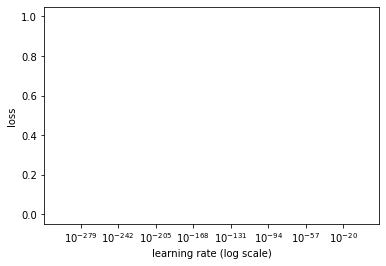

In [0]:
lr_1.plot_loss(n_skip_end=10)

In [0]:
lr_2 = iterate_lr_finder(start_lr=0.0001,end_lr=0.1)

Epoch 1/10
20/20 [==============================] - 16s 789ms/step - loss: 13.1285 - gender_output_loss: 0.8357 - image_quality_output_loss: 1.2657 - age_output_loss: 2.1119 - weight_output_loss: 1.6544 - bag_output_loss: 1.2276 - pose_output_loss: 1.7073 - footwear_output_loss: 2.6203 - emotion_output_loss: 1.7054 - gender_output_weighted_acc: 0.5906 - image_quality_output_weighted_acc: 0.4812 - age_output_weighted_acc: 0.2094 - weight_output_weighted_acc: 0.4313 - bag_output_weighted_acc: 0.4656 - pose_output_weighted_acc: 0.5375 - footwear_output_weighted_acc: 0.3875 - emotion_output_weighted_acc: 0.6438
Epoch 2/10
20/20 [==============================] - 6s 305ms/step - loss: 9.7972 - gender_output_loss: 0.8988 - image_quality_output_loss: 1.1789 - age_output_loss: 1.7904 - weight_output_loss: 1.0766 - bag_output_loss: 1.1673 - pose_output_loss: 1.1879 - footwear_output_loss: 1.2466 - emotion_output_loss: 1.2506 - gender_output_weighted_acc: 0.5031 - image_quality_output_weighted_a

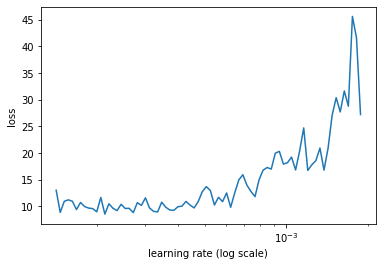

In [0]:
lr_2.plot_loss(n_skip_end=1)

In [0]:
lr_3 = iterate_lr_finder(start_lr=0.00001,end_lr=0.0001)

Epoch 1/10
20/20 [==============================] - 16s 823ms/step - loss: 21.6206 - gender_output_loss: 1.3428 - image_quality_output_loss: 1.3362 - age_output_loss: 3.0587 - weight_output_loss: 3.1542 - bag_output_loss: 1.5799 - pose_output_loss: 2.3407 - footwear_output_loss: 5.9119 - emotion_output_loss: 2.8962 - gender_output_weighted_acc: 0.4375 - image_quality_output_weighted_acc: 0.5125 - age_output_weighted_acc: 0.1250 - weight_output_weighted_acc: 0.0781 - bag_output_weighted_acc: 0.3844 - pose_output_weighted_acc: 0.3281 - footwear_output_weighted_acc: 0.3906 - emotion_output_weighted_acc: 0.3187
Epoch 2/10
20/20 [==============================] - 6s 313ms/step - loss: 16.1637 - gender_output_loss: 0.9012 - image_quality_output_loss: 1.1871 - age_output_loss: 2.4801 - weight_output_loss: 1.7392 - bag_output_loss: 1.3812 - pose_output_loss: 1.8254 - footwear_output_loss: 4.3448 - emotion_output_loss: 2.3047 - gender_output_weighted_acc: 0.5062 - image_quality_output_weighted_

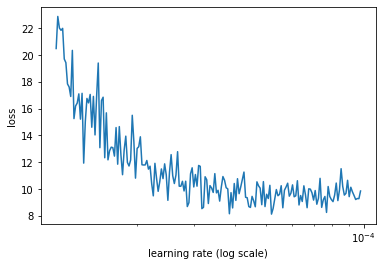

In [0]:
lr_3.plot_loss(n_skip_end=1)

In [0]:
print(lr_finder.get_best_lr(1,1,1))
print(lr_finder.get_best_lr(10,1,1))
print(lr_finder.get_best_lr(20,1,1))

In [0]:
np.min(lr_finder.losses)

In [0]:
print("Max:", np.max(lr_finder.losses),lr_finder.lrs[np.argmax(lr_finder.losses)])
print("Min:", np.min(lr_finder.losses), lr_finder.lrs[np.argmin(lr_finder.losses)])

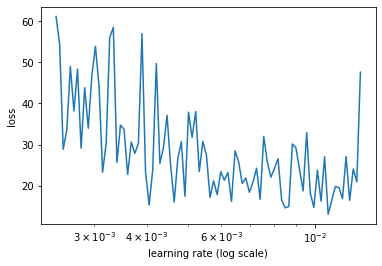

In [0]:
lr_finder.plot_loss(n_skip_end=1)

In [0]:
#wrn_28_10=create_model()
from keras.models import load_model
# import the necessary packages
from keras.callbacks import BaseLogger
import matplotlib.pyplot as plt
import numpy as np
import json
import os

# class LossHistory(keras.callbacks.Callback):
# 	def on_train_begin(self, logs={}):
# 		print("Clearing saved content on training start")
# 		self.losses = []
# 		self.best = np.Inf

class TrainingMonitor(BaseLogger):
	def __init__(self, figPath, jsonPath=None, startAt=0, backup_hist=True):
		# store the output path for the figure, the path to the JSON
		# serialized file, and the starting epoch
		super(TrainingMonitor, self).__init__()
		self.figPath = figPath
		self.jsonPath = jsonPath
		self.startAt = startAt
		self.backup_hist = backup_hist
		print("JSON path:",self.jsonPath)

	def on_train_begin(self, logs={}):
		# initialize the history dictionary
		self.H = {}
		#self.losses = []

		# if the JSON history path exists, load the training history
		if self.jsonPath is not None:
			if os.path.exists(self.jsonPath) and (self.backup_hist == True):
				#self.H = json.loads(open(self.jsonPath).read())
				backup_file_name=self.jsonPath+str(get_curr_time())+"_backup"
				print("Backing up history file:",self.jsonPath," to:",backup_file_name)
				os.rename(self.jsonPath,backup_file_name) 

				# # check to see if a starting epoch was supplied
				# if self.startAt > 0:
				# 	# loop over the entries in the history log and
				# 	# trim any entries that are past the starting
				# 	# epoch
				# 	for k in self.H.keys():
				# 		self.H[k] = self.H[k][:self.startAt]

	def on_epoch_end(self, epoch, logs={}):
		# loop over the logs and update the loss, accuracy, etc.
		# for the entire training process
		for (k, v) in logs.items():
			l = self.H.get(k, [])
			l.append(float(v))
			self.H[k] = l

		# check to see if the training history should be serialized
		# to file
		if self.jsonPath is not None:
			f = open(self.jsonPath, "w")
			f.write(json.dumps(self.H))
			f.close()


import os
plotPath = png_file
jsonPath = json_file
print(plotPath,jsonPath)

/content/gdrive/My Drive/png_wrn2_widrn_acc_res50_1577513556.png /content/gdrive/My Drive/json_wrn2_widrn_acc_res50_1577513556.json


In [0]:
from datetime import datetime
# Prepare model model saving directory.
import os
save_dir = os.path.join('/content/gdrive/', 'My Drive')

model_name = 'assignment5_%s_model.{epoch:03d}.h5' % (model_name_itr)
print(model_name)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# # Prepare callbacks for model saving and for learning rate adjustment.
# checkpoint = ModelCheckpoint(filepath=filepath,
#                              monitor='val_loss',
#                              verbose=1,
#                              save_best_only=True,
#                              mode='min')

assignment5_wrn2_widrn_acc_res50_1577513556_model.{epoch:03d}.h5


In [0]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.callbacks import CyclicLR

In [0]:
EPOCHS=50
#LEARNING_RATE=1.3513402*0.1
#LEARNING_RATE=0.18883973*0.1
#LEARNING_RATE=0.5037587*0.1
#LEARNING_RATE=3.07534*0.1
LEARNING_RATE=0.0029628598*0.1

test_y = np.linspace(0,EPOCHS,EPOCHS)
x=[0, (EPOCHS+1)//5, EPOCHS]
y=[LEARNING_RATE*0.01, LEARNING_RATE, LEARNING_RATE*0.01]
interp_lr = np.interp(test_y, x, y)
def one_lr_schedule(epoch):
    # if(epoch <= 15):
    #     print("lr:",interp_lr[epoch+84],epoch)
    #     return interp_lr[epoch+84]
    print("lr:",interp_lr[epoch],epoch)
    return interp_lr[epoch]



clr = CyclicLR(
    base_lr=LEARNING_RATE*0.01,
    max_lr=LEARNING_RATE,
    step_size=STEPS_PER_EPOCH*4,
    mode='triangular2')


#interp_values = np.interp(, [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])
lr_scheduler = LearningRateScheduler(one_lr_schedule)
callbacks = [checkpoint, 
             #lr_scheduler,
             clr,
             TrainingMonitor(figPath=plotPath,jsonPath=jsonPath,startAt=0)]
                                                      

In [0]:
from datetime import datetime
# Prepare model model saving directory.
import os
save_dir = os.path.join('/content/gdrive/', 'My Drive')

model_name = 'a5_%s_model.{epoch:03d}.h5' % (model_name_itr)
print(model_name)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

def generate_new_callbacks(steps_per_epoch=50,epoch_count=50,min_lr=0.00001, max_lr=0.1):
    local_clr = CyclicLR(base_lr=min_lr,
                            max_lr=max_lr,
                            step_size=steps_per_epoch*4,
                            mode='triangular')
    checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
    training_mon = TrainingMonitor(figPath=plotPath,
                                   jsonPath=jsonPath,
                                   startAt=0)
    
    ########## Introduced after 2x100 Epochs
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=25, 
                                                    restore_best_weights=True) 
    print("Returning new callback array with steps_per_epoch=",steps_per_epoch,
          "min_lr=",min_lr,
          "max_lr=",max_lr,
          "epoch_count=",epoch_count
          )
    callback_array = [local_clr, checkpoint, training_mon, early_stop]
    return callback_array

a5_wrn2_widrn_acc_res50_1577513556_model.{epoch:03d}.h5


In [0]:
history = [0] * 200

In [0]:
#del model
STEPS_PER_EPOCH=30
EPOCHS=100
#LEARNING_RATE=0.0029628598*0.1
LEARNING_RATE=5.1880026e-05
callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                     epoch_count=EPOCHS,
                                     min_lr=LEARNING_RATE*0.01, 
                                     max_lr=LEARNING_RATE)
#model = Model(inputs=Input(shape=(224,224,3)), outputs=output_layers)
model.compile(
    optimizer=SGD(lr=0.0009999997),
    #,momentum=MOMENTUM, nesterov=True),
    #optimizer=SGD(lr=0.01191919191919192),
    loss=tf.keras.losses.CategoricalCrossentropy(),     
    metrics=["accuracy"]
    #weighted_metrics=["accuracy"]
)


model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks,
    steps_per_epoch=STEPS_PER_EPOCH
    #class_weight=loss_weights_train
)

JSON path: /content/gdrive/My Drive/json_wrn2_widrn_acc_incept_1577480753.json
Returning new callback array with steps_per_epoch= 30 min_lr= 5.1880026e-07 max_lr= 5.1880026e-05 epoch_count= 100
Epoch 1/100
 3/30 [==>...........................] - ETA: 1:49 - loss: 25.4663 - gender_output_loss: 1.6331 - image_quality_output_loss: 1.1963 - age_output_loss: 3.5952 - weight_output_loss: 3.8184 - bag_output_loss: 1.7732 - pose_output_loss: 3.0992 - footwear_output_loss: 6.8464 - emotion_output_loss: 3.5045 - gender_output_acc: 0.4583 - image_quality_output_acc: 0.5833 - age_output_acc: 0.0833 - weight_output_acc: 0.0833 - bag_output_acc: 0.3333 - pose_output_acc: 0.3542 - footwear_output_acc: 0.2708 - emotion_output_acc: 0.1667

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.578856). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


30/30 [==============================] - 35s 1s/step - loss: 22.9955 - gender_output_loss: 1.3929 - image_quality_output_loss: 1.2802 - age_output_loss: 3.2824 - weight_output_loss: 3.5665 - bag_output_loss: 1.5301 - pose_output_loss: 2.5028 - footwear_output_loss: 6.2413 - emotion_output_loss: 3.1992 - gender_output_acc: 0.4583 - image_quality_output_acc: 0.5417 - age_output_acc: 0.0896 - weight_output_acc: 0.0708 - bag_output_acc: 0.4062 - pose_output_acc: 0.3250 - footwear_output_acc: 0.3375 - emotion_output_acc: 0.2812 - val_loss: 10.7386 - val_gender_output_loss: 0.8536 - val_image_quality_output_loss: 1.0395 - val_age_output_loss: 1.8664 - val_weight_output_loss: 1.5444 - val_bag_output_loss: 1.1571 - val_pose_output_loss: 1.2762 - val_footwear_output_loss: 1.3693 - val_emotion_output_loss: 1.6321 - val_gender_output_acc: 0.4247 - val_image_quality_output_acc: 0.5556 - val_age_output_acc: 0.0497 - val_weight_output_acc: 0.0655 - val_bag_output_acc: 0.3238 - val_pose_output_acc: 0

NameError: ignored

In [0]:
STEPS_PER_EPOCH=100
EPOCHS=100
#LEARNING_RATE=0.0029628598*0.1
LEARNING_RATE=5.1880026e-05
callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                     epoch_count=EPOCHS,
                                     min_lr=LEARNING_RATE*0.01, 
                                     max_lr=LEARNING_RATE)
#model = Model(inputs=Input(shape=(224,224,3)), outputs=output_layers)

model.load_weights('/content/gdrive/My Drive/a5_wrn2_widrn_acc_incept_1577480753_model.015.h5')
model.compile(
    optimizer=SGD(lr=0.0009999997),
    #,momentum=MOMENTUM, nesterov=True),
    #optimizer=SGD(lr=0.01191919191919192),
    loss=tf.keras.losses.CategoricalCrossentropy(),     
    metrics=["accuracy"]
    #weighted_metrics=["accuracy"]
)

model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks,
    steps_per_epoch=STEPS_PER_EPOCH
    #class_weight=loss_weights_train
)

JSON path: /content/gdrive/My Drive/json_wrn2_widrn_acc_res50_1577487572.json
Returning new callback array with steps_per_epoch= 100 min_lr= 5.1880026e-07 max_lr= 5.1880026e-05 epoch_count= 100



Epoch 1/100
  3/100 [..............................] - ETA: 8:55 - loss: 9.0518 - gender_output_loss: 0.7304 - image_quality_output_loss: 1.2029 - age_output_loss: 1.6414 - weight_output_loss: 0.9190 - bag_output_loss: 1.0883 - pose_output_loss: 1.0102 - footwear_output_loss: 1.4156 - emotion_output_loss: 1.0441 - gender_output_acc: 0.6458 - image_quality_output_acc: 0.5000 - age_output_acc: 0.2917 - weight_output_acc: 0.7708 - bag_output_acc: 0.6458 - pose_output_acc: 0.5625 - footwear_output_acc: 0.4583 - emotion_output_acc: 0.6875 

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143145). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 59s 591ms/step - loss: 9.5170 - gender_output_loss: 0.8406 - image_quality_output_loss: 1.2036 - age_output_loss: 1.7229 - weight_output_loss: 1.1861 - bag_output_loss: 1.0853 - pose_output_loss: 1.1119 - footwear_output_loss: 1.2414 - emotion_output_loss: 1.1251 - gender_output_acc: 0.5238 - image_quality_output_acc: 0.4669 - age_output_acc: 0.3169 - weight_output_acc: 0.5913 - bag_output_acc: 0.4881 - pose_output_acc: 0.5337 - footwear_output_acc: 0.3981 - emotion_output_acc: 0.6569 - val_loss: 9.5898 - val_gender_output_loss: 0.8977 - val_image_quality_output_loss: 1.1935 - val_age_output_loss: 1.7240 - val_weight_output_loss: 1.1893 - val_bag_output_loss: 1.1223 - val_pose_output_loss: 1.0819 - val_footwear_output_loss: 1.2639 - val_emotion_output_loss: 1.1172 - val_gender_output_acc: 0.4985 - val_image_quality_output_acc: 0.4670 - val_age_output_acc: 0.3356 - val_weight_output_acc: 0.5595 - val_bag_output_acc: 0.4902 - val_pose_output_acc

In [0]:
STEPS_PER_EPOCH=200
EPOCHS=100
#LEARNING_RATE=0.0029628598*0.1
LEARNING_RATE=5.1880026e-05
callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                     epoch_count=EPOCHS,
                                     min_lr=LEARNING_RATE*0.01, 
                                     max_lr=LEARNING_RATE)
#model = Model(inputs=Input(shape=(224,224,3)), outputs=output_layers)
# model.compile(
#     optimizer=SGD(lr=0.0009999997),
#     #,momentum=MOMENTUM, nesterov=True),
#     #optimizer=SGD(lr=0.01191919191919192),
#     loss=tf.keras.losses.CategoricalCrossentropy(),     
#     metrics=["accuracy"]
#     #weighted_metrics=["accuracy"]
# )
#model.load_weights('/content/gdrive/My Drive/a5_wrn2_widrn_acc_incept_1577480753_model.015.h5')

model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks,
    steps_per_epoch=STEPS_PER_EPOCH
    #class_weight=loss_weights_train
)

In [0]:
#del model
STEPS_PER_EPOCH=100
EPOCHS=100
LEARNING_RATE=0.0029628598*0.1

callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                     epoch_count=EPOCHS,
                                     min_lr=LEARNING_RATE*0.01, 
                                     max_lr=LEARNING_RATE)
#model = Model(inputs=Input(shape=(224,224,3)), outputs=output_layers)
# model.compile(
#     optimizer=SGD(lr=0.0009999997),
#     #,momentum=MOMENTUM, nesterov=True),
#     #optimizer=SGD(lr=0.01191919191919192),
#     loss=tf.keras.losses.CategoricalCrossentropy(),     
#     metrics=["accuracy"]
#     #weighted_metrics=["accuracy"]
# )
model.load_weights('/content/gdrive/My Drive/a5_wrn2_widrn_acc_incept_1577473943_model.062.h5')

history[0]=model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks,
    steps_per_epoch=STEPS_PER_EPOCH
    #class_weight=loss_weights_train
)

JSON path: /content/gdrive/My Drive/json_wrn2_widrn_acc_incept_1577473943.json
Returning new callback array with steps_per_epoch= 100 min_lr= 2.9628598000000003e-06 max_lr= 0.00029628598 epoch_count= 100
Backing up history file: /content/gdrive/My Drive/json_wrn2_widrn_acc_incept_1577473943.json  to: /content/gdrive/My Drive/json_wrn2_widrn_acc_incept_1577473943.json1577476781_backup
Epoch 1/100
100/100 [==============================] - 41s 406ms/step - loss: 7.9917 - gender_output_loss: 0.6921 - image_quality_output_loss: 0.9668 - age_output_loss: 1.4459 - weight_output_loss: 1.0272 - bag_output_loss: 0.9280 - pose_output_loss: 0.9803 - footwear_output_loss: 1.0492 - emotion_output_loss: 0.9021 - gender_output_acc: 0.5687 - image_quality_output_acc: 0.5700 - age_output_acc: 0.3888 - weight_output_acc: 0.6188 - bag_output_acc: 0.5487 - pose_output_acc: 0.5850 - footwear_output_acc: 0.4513 - emotion_output_acc: 0.7225 - val_loss: 7.8057 - val_gender_output_loss: 0.6975 - val_image_qual

In [0]:
history = [0]*100

In [0]:
STEPS_PER_EPOCH=200
EPOCHS=50
LEARNING_RATE=0.0029628598*0.15

callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                     epoch_count=EPOCHS,
                                     min_lr=LEARNING_RATE*0.01, 
                                     max_lr=LEARNING_RATE)

model.load_weights('/content/gdrive/My Drive/a5_wrn2_widrn_acc_res50_1577487572_model.072.h5')
#model = Model(inputs=Input(shape=(224,224,3)), outputs=output_layers)
model.compile(
    optimizer=SGD(lr=0.0009999997),
    #,momentum=MOMENTUM, nesterov=True),
    #optimizer=SGD(lr=0.01191919191919192),
    loss=tf.keras.losses.CategoricalCrossentropy(),     
    metrics=["accuracy"]
    #weighted_metrics=["accuracy"]
)

history[0]=model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks,
    steps_per_epoch=STEPS_PER_EPOCH
    #class_weight=loss_weights_train
)

JSON path: /content/gdrive/My Drive/json_wrn2_widrn_acc_res50_1577513556.json
Returning new callback array with steps_per_epoch= 200 min_lr= 4.4442896999999994e-06 max_lr= 0.00044442896999999994 epoch_count= 50



Epoch 1/50
200/200 [==============================] - 94s 472ms/step - loss: 9.1225 - gender_output_loss: 0.8258 - image_quality_output_loss: 1.1641 - age_output_loss: 1.6126 - weight_output_loss: 1.1339 - bag_output_loss: 1.0812 - pose_output_loss: 1.0678 - footwear_output_loss: 1.1973 - emotion_output_loss: 1.0397 - gender_output_acc: 0.5175 - image_quality_output_acc: 0.4688 - age_output_acc: 0.3397 - weight_output_acc: 0.5806 - bag_output_acc: 0.4762 - pose_output_acc: 0.5628 - footwear_output_acc: 0.4147 - emotion_output_acc: 0.6856 - val_loss: 9.3593 - val_gender_output_loss: 0.8180 - val_image_quality_output_loss: 1.1650 - val_age_output_loss: 1.7312 - val_weight_output_loss: 1.1509 - val_bag_output_loss: 1.0671 - val_pose_output_loss: 1.1259 - val_footwear_output_loss

In [0]:
train_df.shape[0]//BATCH_SIZE//2

360

In [0]:
STEPS_PER_EPOCH=train_df.shape[0]//BATCH_SIZE//2
EPOCHS=50
LEARNING_RATE=0.0029628598*0.15

callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                     epoch_count=EPOCHS,
                                     min_lr=LEARNING_RATE*0.01, 
                                     max_lr=LEARNING_RATE)

model.load_weights('/content/gdrive/My Drive/a5_wrn2_widrn_acc_res50_1577513556_model.048.h5')
#model = Model(inputs=Input(shape=(224,224,3)), outputs=output_layers)
model.compile(
    optimizer=SGD(lr=0.0009999997),
    #,momentum=MOMENTUM, nesterov=True),
    #optimizer=SGD(lr=0.01191919191919192),
    loss=tf.keras.losses.CategoricalCrossentropy(),     
    metrics=["accuracy"]
    #weighted_metrics=["accuracy"]
)

history[0]=model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks,
    steps_per_epoch=STEPS_PER_EPOCH
    #class_weight=loss_weights_train
)

JSON path: /content/gdrive/My Drive/json_wrn2_widrn_acc_res50_1577513556.json
Returning new callback array with steps_per_epoch= 360 min_lr= 4.4442896999999994e-06 max_lr= 0.00044442896999999994 epoch_count= 50
Backing up history file: /content/gdrive/My Drive/json_wrn2_widrn_acc_res50_1577513556.json  to: /content/gdrive/My Drive/json_wrn2_widrn_acc_res50_1577513556.json1577518503_backup
Epoch 1/50
360/360 [==============================] - 141s 392ms/step - loss: 8.0056 - gender_output_loss: 0.6836 - image_quality_output_loss: 1.0099 - age_output_loss: 1.4628 - weight_output_loss: 0.9874 - bag_output_loss: 0.9514 - pose_output_loss: 0.9511 - footwear_output_loss: 1.0241 - emotion_output_loss: 0.9352 - gender_output_acc: 0.5681 - image_quality_output_acc: 0.5318 - age_output_acc: 0.3696 - weight_output_acc: 0.6372 - bag_output_acc: 0.5349 - pose_output_acc: 0.6054 - footwear_output_acc: 0.4922 - emotion_output_acc: 0.7073 - val_loss: 7.8891 - val_gender_output_loss: 0.6773 - val_image

In [0]:
print("End of EPOCHS=",EPOCHS," STEPS_PER_EPOCH=",STEPS_PER_EPOCH)

End of EPOCHS= 50  STEPS_PER_EPOCH= 360


In [0]:
STEPS_PER_EPOCH=train_df.shape[0]//BATCH_SIZE
EPOCHS=50
LEARNING_RATE=0.0029628598*0.1

callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                     epoch_count=EPOCHS,
                                     min_lr=LEARNING_RATE*0.01, 
                                     max_lr=LEARNING_RATE)

model.load_weights('/content/gdrive/My Drive/a5_wrn2_widrn_acc_res50_1577513556_model.048.h5')
#model = Model(inputs=Input(shape=(224,224,3)), outputs=output_layers)
model.compile(
    optimizer=SGD(lr=0.0009999997),
    #,momentum=MOMENTUM, nesterov=True),
    #optimizer=SGD(lr=0.01191919191919192),
    loss=tf.keras.losses.CategoricalCrossentropy(),     
    metrics=["accuracy"]
    #weighted_metrics=["accuracy"]
)

history[0]=model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks,
    steps_per_epoch=STEPS_PER_EPOCH
    #class_weight=loss_weights_train
)

JSON path: /content/gdrive/My Drive/json_wrn2_widrn_acc_res50_1577513556.json
Returning new callback array with steps_per_epoch= 721 min_lr= 2.9628598000000003e-06 max_lr= 0.00029628598 epoch_count= 50
Backing up history file: /content/gdrive/My Drive/json_wrn2_widrn_acc_res50_1577513556.json  to: /content/gdrive/My Drive/json_wrn2_widrn_acc_res50_1577513556.json1577526326_backup
Epoch 1/50
720/721 [============================>.] - ETA: 0s - loss: 7.7881 - gender_output_loss: 0.6572 - image_quality_output_loss: 0.9853 - age_output_loss: 1.4245 - weight_output_loss: 0.9845 - bag_output_loss: 0.9151 - pose_output_loss: 0.9238 - footwear_output_loss: 0.9866 - emotion_output_loss: 0.9111 - gender_output_acc: 0.6025 - image_quality_output_acc: 0.5501 - age_output_acc: 0.3920 - weight_output_acc: 0.6339 - bag_output_acc: 0.5571 - pose_output_acc: 0.6148 - footwear_output_acc: 0.5234 - emotion_output_acc: 0.7120Epoch 1/50
Epoch 1/50
721/721 [==============================] - 262s 363ms/step 

In [0]:
history[1]=model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,
    #class_weight=loss_weights_train
    callbacks =callbacks
)

In [0]:
history[2]=model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,
    #class_weight=loss_weights_train
    callbacks =callbacks
)

In [0]:
#wrn_28_10.save('wrn_level_4.h5')

In [0]:
from matplotlib import pyplot as plt
import math
from keras.callbacks import LambdaCallback
import keras.backend as K
import numpy as np


class LRFinder_new:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9
    def on_train_begin(self, logs={}):
        print("LRFinder will reset best weights")
        self.losses=[]
        self.best = np.Inf

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            print("")
            print("Training stopped due to high loss",loss)
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmax(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]
